In [1]:
import jax
import jax.numpy as jnp # type: ignore
import numpy as np # type: ignore

from jax import grad, jit, vmap, pmap # type: ignore
import matplotlib.pyplot as plt


In [2]:
simple_pytree = [
    [9, 5, None],
    [3, (2, 8)],
    {"p": 78},
    {"q": {"r": 5, "s": {"t": 100, "u": 200}}},
    4
]

for elem in simple_pytree:
    leaves = jax.tree_util.tree_leaves(elem)
    print(f"{elem} contains {len(leaves)} leaves ... {leaves}")

[9, 5, None] contains 2 leaves ... [9, 5]
[3, (2, 8)] contains 3 leaves ... [3, 2, 8]
{'p': 78} contains 1 leaves ... [78]
{'q': {'r': 5, 's': {'t': 100, 'u': 200}}} contains 3 leaves ... [5, 100, 200]
4 contains 1 leaves ... [4]


In [3]:
print(jax.tree_util.tree_map(lambda x: x**2, simple_pytree))

[[81, 25, None], [9, (4, 64)], {'p': 6084}, {'q': {'r': 25, 's': {'t': 10000, 'u': 40000}}}, 16]


In [4]:
# For the above, we can use multiple different pytrees but they must have the same structure in order to be operated together.

In [5]:
def init_mlp_params(layer_widths):
    params = []

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weight=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
                bias=np.ones(shape=(n_out,))
            )
        )
    
    return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree_util.tree_map(lambda x: x.shape, params)

[{'bias': (128,), 'weight': (1, 128)},
 {'bias': (128,), 'weight': (128, 128)},
 {'bias': (1,), 'weight': (128, 1)}]

In [6]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x  = jax.nn.relu(jnp.dot(x, layer["weight"]) + layer["bias"])

    return jnp.dot(x, last["weight"]) + last["bias"]

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

lr = 0.0001

@jit
def update(params, x, y):

    grads = jax.grad(loss_fn)(params, x, y)

    return jax.tree.map(lambda p, g: p - lr * g, params, grads)

2024-08-19 21:00:58.369788: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.1 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


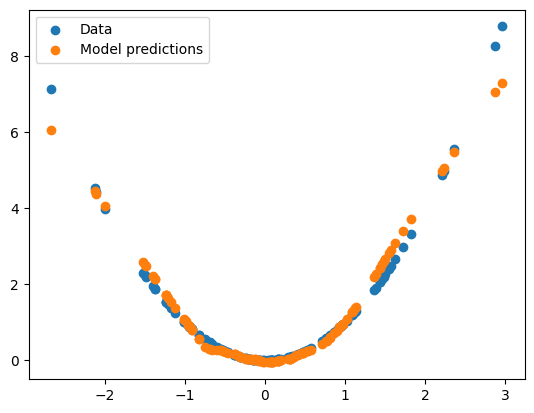

In [7]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys, label="Data")
plt.scatter(xs, forward(params, xs), label="Model predictions")
plt.legend()

In [8]:
class ExampleObject:
    def __init__(self, name, x, y, z):
        self.name = name
        self.x = x
        self.y = y
        self.z = z

custom_pytree = [ExampleObject("Jamie", 2, 1, 3), ExampleObject("McGowan", 1, 9, 6)]

leaves = jax.tree_util.tree_leaves(custom_pytree)
print(f"{custom_pytree} contains {len(leaves)} leaves ... {leaves}")

[<__main__.ExampleObject object at 0x7f59601c6de0>, <__main__.ExampleObject object at 0x7f5960145580>] contains 2 leaves ... [<__main__.ExampleObject object at 0x7f59601c6de0>, <__main__.ExampleObject object at 0x7f5960145580>]


In [9]:
def flatten_ExampleObject(obj):
    flat_content = [obj.x, obj.y, obj.z]

    aux_data = obj.name

    return flat_content, aux_data


def unflatten_ExampleObject(aux_data, flat_content):
    return ExampleObject(aux_data, *flat_content)


jax.tree_util.register_pytree_node(ExampleObject, flatten_ExampleObject, unflatten_ExampleObject)

In [10]:
leaves = jax.tree_util.tree_leaves(custom_pytree)
print(f"{custom_pytree} contains {len(leaves)} leaves ... {leaves}")

[<__main__.ExampleObject object at 0x7f59601c6de0>, <__main__.ExampleObject object at 0x7f5960145580>] contains 6 leaves ... [2, 1, 3, 1, 9, 6]


In [11]:
result = jax.tree_util.tree_map(lambda x: x + 1, custom_pytree)
jax.tree_util.tree_leaves(result)

[3, 2, 4, 2, 10, 7]

In [12]:
zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

shapes = jax.tree.map(lambda x: x.shape, zeros_tree)
print(shapes)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]
[(2, 3), (3, 4)]


In [13]:
ones_tree = jax.tree.map(jnp.ones, shapes)

print(ones_tree)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


In [14]:
jax.tree_util.tree_leaves(shapes)

[2, 3, 3, 4]

In [15]:
new_shapes = jax.tree.map(lambda x: jnp.array(x.shape), zeros_tree)
new_ones_tree = jax.tree.map(jnp.ones, new_shapes)

print(new_ones_tree)

[Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


In [16]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [17]:
x = np.arange(5)
w = np.array([2., 3., 5.])

def convolve(w, x):
    output = []

    for i in range(1, len(x) - 1):
        output.append(jnp.dot(x[i-1:i+2], w))
    
    return jnp.array(output)

result = convolve(w, x)
print(repr(result))

Array([13., 23., 33.], dtype=float32)


In [18]:
n_devices = jax.local_device_count()
print(f"Number of devices {n_devices}")

Number of devices 4


In [19]:
x_batch = np.arange(n_devices * 5).reshape(n_devices, 5)
ws = np.stack([w] * n_devices)

print(x_batch.shape, ws.shape)

(4, 5) (4, 3)


In [20]:
vmap_result = jax.vmap(convolve, in_axes=(0, 0))(ws, x_batch)
print(vmap_result)

[[ 13.  23.  33.]
 [ 63.  73.  83.]
 [113. 123. 133.]
 [163. 173. 183.]]


In [21]:
pmap_result = jax.pmap(convolve, in_axes=(0, 0))(ws, x_batch)
print(pmap_result)

[[ 13.  23.  33.]
 [ 63.  73.  83.]
 [113. 123. 133.]
 [163. 173. 183.]]


In [22]:
double_pmap_result = jax.pmap(convolve)(
    jax.pmap(convolve, in_axes=(0, 0))(ws, x_batch), x_batch
)
print(double_pmap_result)

[[  89.  158.  227.]
 [1334. 1553. 1772.]
 [4079. 4448. 4817.]
 [8324. 8843. 9362.]]


In [23]:
pmap_result = jax.pmap(convolve, in_axes=(None, 0))(w, x_batch)
print(pmap_result)

[[ 13.  23.  33.]
 [ 63.  73.  83.]
 [113. 123. 133.]
 [163. 173. 183.]]


In [24]:
# Communicating between cores when we accumulate gradients from multiple batches

In [25]:
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)

    return output / jax.lax.psum(output, axis_name='batch_dim')

res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, x_batch) # automatically calls jit in the background
res_vmap = jax.vmap(normalized_convolution, axis_name="batch_dim", in_axes=(None, 0))(
    w, x_batch
)

print(jnp.allclose(res_pmap, res_vmap))

True


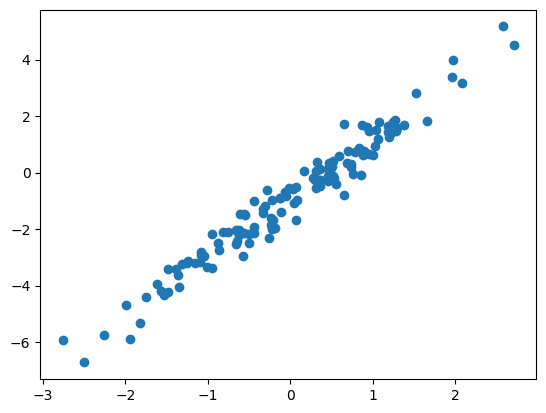

In [26]:
true_w, true_b = 2, -1

xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys, label="Data")

In [27]:
import functools
from typing import NamedTuple

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)

def forward(params, x):
    return params.weight * x + params.bias

def loss_fn(params, x, y):
    pred = forward(params, x)
    return jnp.mean((pred - y) ** 2)

@functools.partial(jax.pmap, axis_name='batch')
def update(params, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    
    grads = jax.lax.pmean(grads, axis_name="batch")

    loss = jax.lax.pmean(loss, axis_name="batch")
    
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, grads)

    return new_params, loss


In [28]:
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x] * n_devices), params)

In [29]:
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

(4, 32, 1) (4, 32, 1)


In [30]:
num_epochs = 10000

for epoch in range(num_epochs):
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss}")

print(f"Final loss: {loss}")


final_params = jax.device_get(jax.tree.map(lambda x: x[0], replicated_params))

Epoch 0: Loss = [4.2677193 4.2677193 4.2677193 4.2677193]
Epoch 100: Loss = [4.095795 4.095795 4.095795 4.095795]
Epoch 200: Loss = [3.9311268 3.9311268 3.9311268 3.9311268]
Epoch 300: Loss = [3.7734084 3.7734084 3.7734084 3.7734084]


Epoch 400: Loss = [3.6223464 3.6223464 3.6223464 3.6223464]
Epoch 500: Loss = [3.4776597 3.4776597 3.4776597 3.4776597]
Epoch 600: Loss = [3.339079 3.339079 3.339079 3.339079]
Epoch 700: Loss = [3.2063465 3.2063465 3.2063465 3.2063465]
Epoch 800: Loss = [3.0792155 3.0792155 3.0792155 3.0792155]
Epoch 900: Loss = [2.9574506 2.9574506 2.9574506 2.9574506]
Epoch 1000: Loss = [2.8408232 2.8408232 2.8408232 2.8408232]
Epoch 1100: Loss = [2.7291176 2.7291176 2.7291176 2.7291176]
Epoch 1200: Loss = [2.6221256 2.6221256 2.6221256 2.6221256]
Epoch 1300: Loss = [2.519649 2.519649 2.519649 2.519649]
Epoch 1400: Loss = [2.4214962 2.4214962 2.4214962 2.4214962]
Epoch 1500: Loss = [2.3274856 2.3274856 2.3274856 2.3274856]
Epoch 1600: Loss = [2.237441 2.237441 2.237441 2.237441]
Epoch 1700: Loss = [2.151197 2.151197 2.151197 2.151197]
Epoch 1800: Loss = [2.0685918 2.0685918 2.0685918 2.0685918]
Epoch 1900: Loss = [1.9894732 1.9894732 1.9894732 1.9894732]
Epoch 2000: Loss = [1.9136932 1.9136932 1.9136

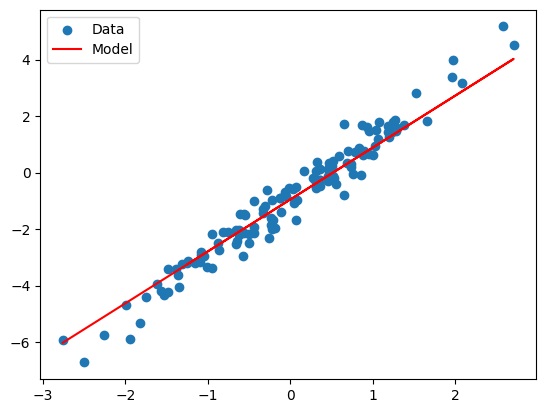

In [31]:
plt.scatter(xs, ys, label="Data")
plt.plot(xs, forward(final_params, xs), c="red", label="Model")
plt.legend()
plt.show();

# Classifying MNIST

In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
seed = 42

def init_MLP(layer_dims, key, scale=0.01):
    """
    Initializes a multi-layer perceptron with the given layer dimensions.
    """
    params = []

    keys = jax.random.split(key, len(layer_dims) - 1)

    for in_dim, out_dim, layer_key in zip(layer_dims[:-1], layer_dims[1:], keys):
        w_key, b_key = jax.random.split(layer_key)
        params.append(
            [
                scale * jax.random.normal(w_key, (out_dim, in_dim)), 
                scale * jax.random.normal(b_key,(out_dim,))
            ]
        )

    return params

# initialize the parameters of the MLP with some random values
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)

# Check the shapes of the parameters
print(jax.tree.map(lambda x: x.shape, MLP_params))

2024-08-19 21:40:06.843368: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.1 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [3]:
from jax.scipy.special import logsumexp

def MLP_predict(params, x):
    """
    Predicts the output of a neural network with given parameters.
    """
    activation = x
    for w, b in params[:-1]:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits)

# Generate some fake data
flat_img = np.random.randn(np.prod(784))
print(flat_img.shape)

# Check the prediction shape matches expectation
prediction = MLP_predict(MLP_params, flat_img)
print(prediction.shape)

(784,)


(10,)


In [4]:
# Wrap single data point function in a vmap to produce batched function - provide the batched argument MLP_predict(params: No batch, x: batch_dim = 0)
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

# Generate fake batched data
batched_flat_img = np.random.randn(16, np.prod(784))
print(batched_flat_img.shape)

# Check batched output matches expectation
batched_prediction = batched_MLP_predict(MLP_params, batched_flat_img)
print(batched_prediction.shape)

(16, 784)


(16, 10)


In [23]:
# Import torchvision MNIST dataloaders
import torch
import torchvision
import torchvision.transforms as transforms

def convert_to_numpy(x: torch.Tensor) -> np.array:
    return np.ravel(np.array(x, dtype=np.float32))

def collate_fn(batch):
    batch = list(zip(*batch))
    return np.stack(batch[0]), np.array(batch[1])


# Define transforms
transform = transforms.Compose([convert_to_numpy])

# Download MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

# Define dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=0, collate_fn=collate_fn, drop_last=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=0, collate_fn=collate_fn, drop_last=True
)

In [24]:
batch_data = next(iter(trainloader))
print(batch_data[0].shape, batch_data[1].shape)
print(type(batch_data[0]), type(batch_data[1]))

(128, 784) (128,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [41]:
num_epochs = 10

def loss_fn(params, images, labels):
    preds = batched_MLP_predict(params, images)

    acc = accuracy(preds, labels) / labels.shape[0]

    return -jnp.mean(preds * labels), acc # labels is a 1hot vector

def accuracy(preds, labels):
    pred_classes = jnp.argmax(preds, axis=1)
    return np.sum(pred_classes == jnp.argmax(labels, axis=1))

@jit
def update(params, imgs, labels, lr=1e-2):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, imgs, labels)

    return jax.tree.map(lambda p, g: p - lr * g, params, grads), loss, acc


# Initialise MLP
MLP_params = init_MLP([784, 512, 512, 10], key)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    for n, (images, labels) in enumerate(trainloader):
        labels = jax.nn.one_hot(labels, len(torchvision.datasets.MNIST.classes))
        MLP_params, loss, acc = update(MLP_params, images, labels)

        if n % 50 == 0:
            print(f"Batch: {n}, Loss: {loss: .6f}, Train Acc.: {100*acc: .6f}")

    test_loss = 0
    test_acc = 0
    for images, labels in testloader:
        labels = jax.nn.one_hot(labels, len(torchvision.datasets.MNIST.classes))
        tl, ta = loss_fn(MLP_params, images, labels)
        test_loss += tl
        test_acc += ta

    print(f"Epoch: {epoch}, Test Loss: {test_loss / len(testloader) : 3f}, Test Acc.: {100*test_acc / len(testloader): .3f}")

Epoch 0


Batch: 0, Loss:  0.258009, Train Acc.:  14.843750
Batch: 50, Loss:  0.065588, Train Acc.:  88.281250
Batch: 100, Loss:  0.049027, Train Acc.:  89.843750
Batch: 150, Loss:  0.047103, Train Acc.:  88.281250
Batch: 200, Loss:  0.040117, Train Acc.:  90.625000
Batch: 250, Loss:  0.038155, Train Acc.:  91.406250
Batch: 300, Loss:  0.026866, Train Acc.:  93.750000
Batch: 350, Loss:  0.024728, Train Acc.:  91.406250
Batch: 400, Loss:  0.025881, Train Acc.:  92.968750
Batch: 450, Loss:  0.020621, Train Acc.:  93.750000
Epoch: 0, Test Loss:  0.027993, Test Acc.:  91.877
Epoch 1
Batch: 0, Loss:  0.028823, Train Acc.:  92.187500
Batch: 50, Loss:  0.029870, Train Acc.:  90.625000
Batch: 100, Loss:  0.023768, Train Acc.:  94.531250
Batch: 150, Loss:  0.027076, Train Acc.:  92.968750
Batch: 200, Loss:  0.016165, Train Acc.:  95.312500
Batch: 250, Loss:  0.021842, Train Acc.:  92.968750
Batch: 300, Loss:  0.020946, Train Acc.:  94.531250
Batch: 350, Loss:  0.023739, Train Acc.:  93.750000
Batch: 400,

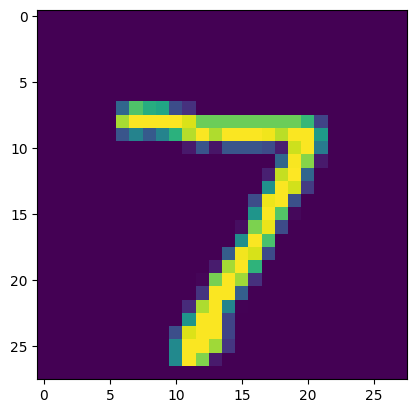

Predicted label: 7, True label: 7


In [27]:
imgs, labels = next(iter(testloader))
example_img = imgs[0].reshape((28, 28))
example_label = labels[0]

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(example_img)))

plt.imshow(example_img)
plt.show()

print(f"Predicted label: {pred}, True label: {example_label}")

In [36]:
from sklearn.manifold import TSNE


def fetch_activations(params, x):
    """
    Predicts the output of a neural network with given parameters.
    """
    all_activations = []
    activation = x
    for w, b in params[:-1]:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        all_activations.append(activation)

    return all_activations

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))

batch_imgs, batch_labels = next(iter(testloader))
batched_activations = batched_fetch_activations(MLP_params, batch_imgs)

print(len(batched_activations))
print(batched_activations[-1].shape)

2
(128, 512)


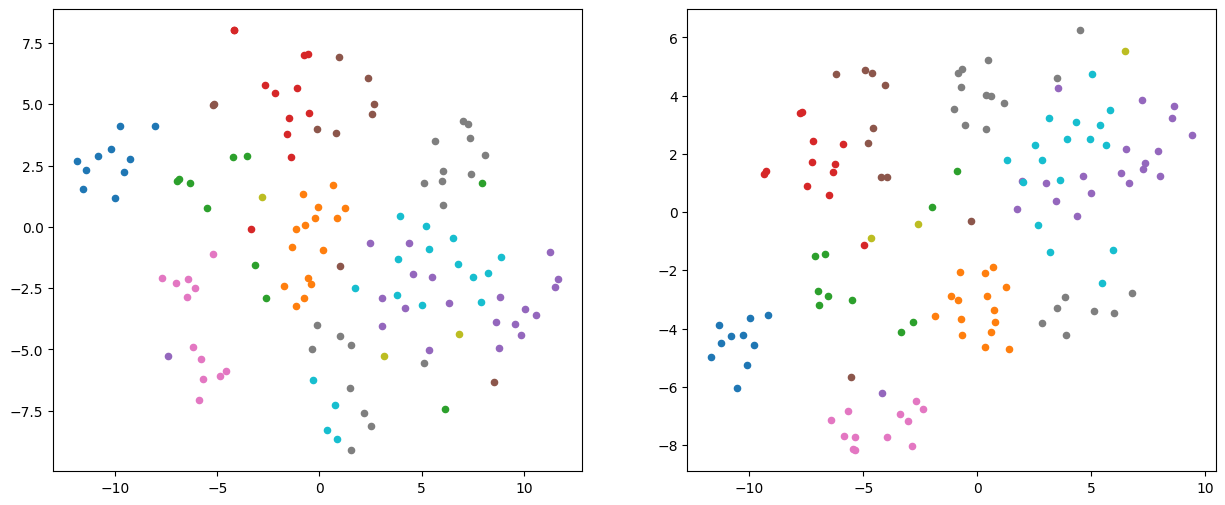

In [39]:
all_tsne_embeddings = [TSNE(n_components=2).fit_transform(x) for x in batched_activations]

fig, axes = plt.subplots(1, len(all_tsne_embeddings), figsize=(15, 6))
axes = axes.ravel()
for ax, tsne_embeddings in zip(axes, all_tsne_embeddings):
    for cls in range(10):
        ax.scatter(
            tsne_embeddings[labels == cls, 0],
            tsne_embeddings[labels == cls, 1],
            s=20,
            label=cls,
        )
plt.show()

In [40]:
dead_neurons = [np.ones(act.shape[1:]) for act in batched_activations]

for layer_id, activations in enumerate(batched_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

0
12
